In [2]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [186]:
# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder

In [4]:
import torch
import numpy as np
import sympy as sp
from util import data2input, prods_to_eq, plot_onehot, load_dataset, logits_to_prefix, logits_to_prods
import wandb
from model import GrammarVAE
import yaml
from matplotlib import pyplot as plt
torch.manual_seed(41)

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240817_2')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)
val_transform = lambda x: torch.arcsinh(x)*0.1
val_transformed = val_transform(torch.tensor(val)).detach().numpy()

# Load model
run = 'qxf0pra1'
wandb_cache_path = f'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/wandb_cache'
with wandb.restore('model.pth', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as io:
    name = io.name
checkpoint = torch.load(name)
# Read the model parameters from the WandB config.yaml file

with wandb.restore('config.yaml', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as config_file:
    config = yaml.safe_load(config_file)

TOKEN_CNT, SEQ_LEN = 10, 15
vae_model = GrammarVAE(
    hidden_encoder_size=config['encoder_hidden']['value'],
    z_dim=config['z_size']['value'],
    conv_size="large",  # config['conv_size']['value'],
    hidden_decoder_size=config['decoder_hidden']['value'],
    token_cnt=config['token_cnt']['value'],
    rnn_type=config['rnn_type']['value'],
    val_points=config['val_points']['value'],
    device='cpu'
)
vae_model.load_state_dict(checkpoint['model_state_dict'])

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_17279/877717881.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(name)


Using updated value decoder 2.0!


<All keys matched successfully>

### Examine std of encoder

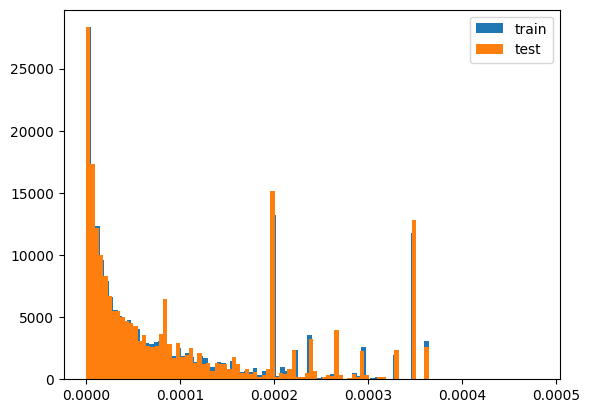

In [106]:
from util import create_dataloader

torch.manual_seed(41)

BATCH_SIZE = 2**15

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 
                                                    'dataset_240817_2', 
                                                    test_split=0.1, 
                                                    batch_size=BATCH_SIZE, # 32k
                                                    value_transform=lambda x: torch.arcsinh(x)*0.1, 
                                                    device='cpu',
                                                    max_length=None)


sigma_norm_train = np.empty(len(train_loader.dataset))
for i, (x, _, _, _) in enumerate(train_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mu, sigma = vae_model.encoder(x)
    res = sigma.norm(dim=1).detach().numpy()
    sigma_norm_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res

sigma_norm_test = np.empty(len(test_loader.dataset))
for i, (x, _, _, _) in enumerate(test_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mu, sigma = vae_model.encoder(x)
    res = sigma.norm(dim=1).detach().numpy()
    sigma_norm_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res

plt.hist(sigma_norm_train, bins=100, label='train', density=True)
plt.hist(sigma_norm_test, bins=100, label='test', density=True)
plt.legend()
plt.show()

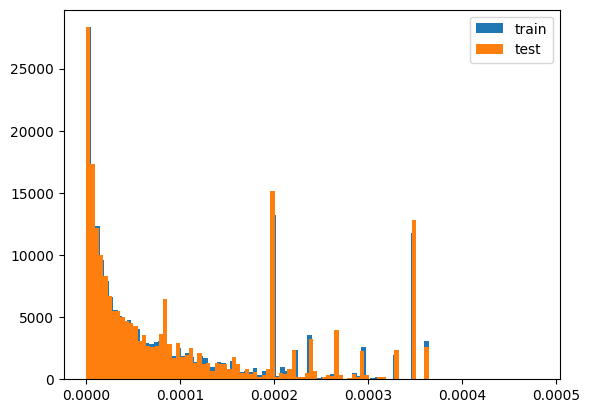

In [100]:
plt.hist(sigma_norm_train, bins=100, label='train', density=True)
plt.hist(sigma_norm_test, bins=100, label='test', density=True)
plt.legend()
plt.show()

### Examine neighbourhood in latent space of training samples 

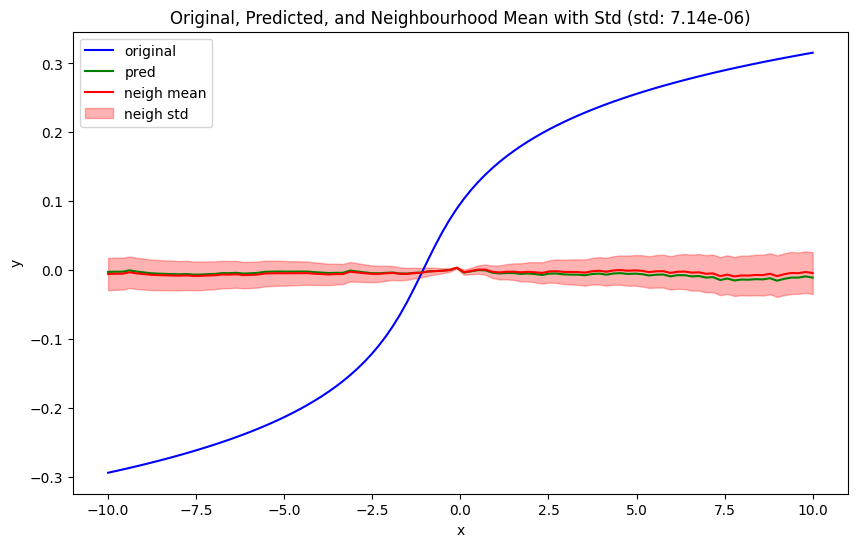

In [137]:
torch.manual_seed(41)

i = 100
x = data2input(data_syntax[i, ...])
# x = all_x[i, ...].unsqueeze(0)

mu, sigma = vae_model.encoder(x)
logits = vae_model.decoder(mu, max_length=15)
values = vae_model.value_decoder(mu)

samples = []
for _ in range(1000):  # Number of samples
    z = vae_model.sample(mu, sigma*1e3)  # Sample from neighbourhood in latent space
    values_neigh = vae_model.value_decoder(z)
    samples.append(values_neigh.squeeze().detach().numpy())
samples = np.array(samples)
mean_samples = np.mean(samples, axis=0)
std_samples = np.std(samples, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(val_x.squeeze(), val_transformed[i, :].squeeze(), label='original', color='blue')
plt.plot(val_x.squeeze(), values.squeeze().detach().numpy(), label='pred', color='green')
plt.plot(val_x.squeeze(), mean_samples, label='neigh mean', color='red')
plt.fill_between(val_x.squeeze(), mean_samples - std_samples, mean_samples + std_samples, 
                 alpha=0.3, color='red', label='neigh std')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Original, Predicted, and Neighbourhood Mean with Std (std: {sigma.norm().item():.2e})')
plt.savefig('latent_analysis.pdf')
plt.show()

# plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
# plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))
# plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))
